<a href="https://colab.research.google.com/github/ted-marlon/Data-Science/blob/main/Mod%C3%A8le_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La consommation de produits saisonniers tels que le chauffage et la crème glacée est fortement influencée par les variations climatiques et présente souvent des dynamiques opposées : lorsque la demande de chauffage augmente en hiver, celle de crème glacée diminue, et vice versa en été.

Dans ce contexte, il est pertinent de s’interroger :
Peut-on modéliser de façon conjointe l’évolution temporelle de ces deux séries afin de capturer leurs interactions dynamiques et produire des prévisions synchronisées, fiables et cohérentes ?

Pour répondre à cette question, nous proposons d’ajuster un modèle autorégressif vectoriel (VAR) sur les séries différenciées de consommation de chauffage et de crème glacée. Ce type de modèle permet de prendre en compte non seulement l’historique de chaque variable, mais aussi l’influence croisée entre elles, ce qui est essentiel pour des prévisions multivariées réalistes.



# Importation des packages et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Charger les données
df = pd.read_csv('ice_cream_vs_heater.csv')
df

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21
...,...,...,...
193,2020-02,34,45
194,2020-03,25,44
195,2020-04,25,53
196,2020-05,27,70


In [3]:
#type de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      198 non-null    object
 1   heater     198 non-null    int64 
 2   ice cream  198 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


In [4]:
# Convertir la colonne 'Month' en datetime
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df

,Month,heater,ice cream
0,2004-01-01,27,13
1,2004-02-01,18,15
2,2004-03-01,14,16
3,2004-04-01,13,19
4,2004-05-01,13,21
...,...,...,...
193,2020-02-01,34,45
194,2020-03-01,25,44
195,2020-04-01,25,53
196,2020-05-01,27,70


In [6]:
# Définir 'Month' comme index
df = df.set_index('Month')
df

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21
...,...,...
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53


# Test de la stationnarité

# Analyse visuelle

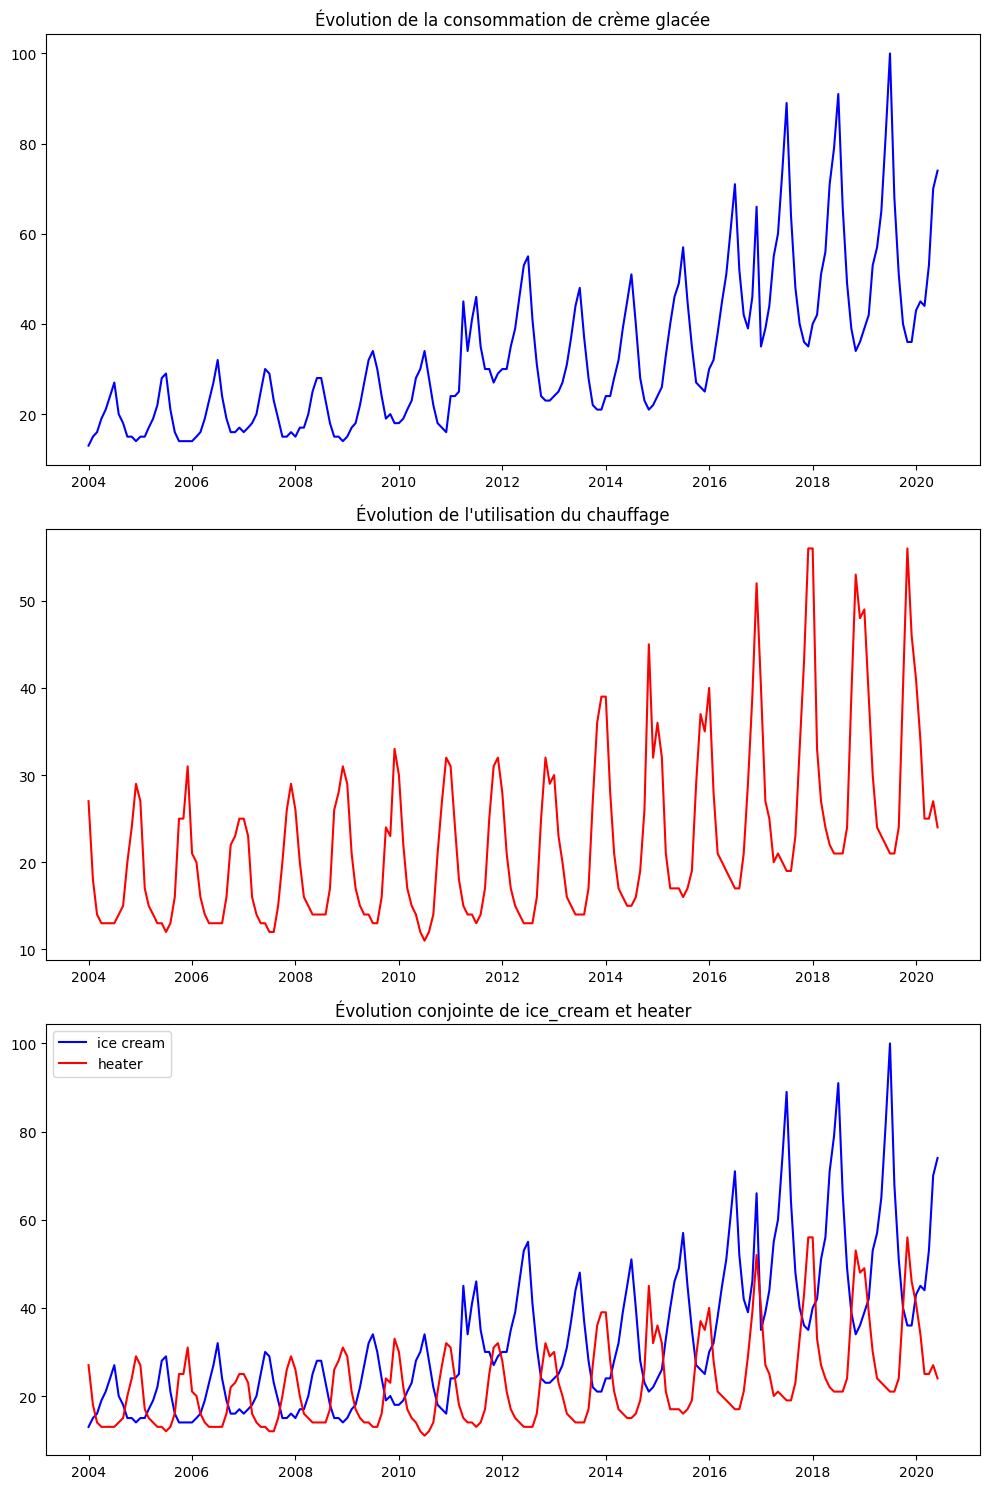

In [7]:
# Description des données
# Créer une figure et des axes
fig, axs = plt.subplots(3, 1, figsize=(10,15))

# Faire le premier sous-graphique pour ice_cream
axs[0].plot(df.index, df['ice cream'], color='blue')
axs[0].set_title('Évolution de la consommation de crème glacée')

# Faire le deuxième sous-graphique pour heater
axs[1].plot(df.index, df['heater'], color='red')
axs[1].set_title('Évolution de l\'utilisation du chauffage')

# Faire le troisième sous-graphique pour ice_cream et heater
axs[2].plot(df.index, df['ice cream'], color='blue', label='ice cream')
axs[2].plot(df.index, df['heater'], color='red', label='heater')
axs[2].set_title('Évolution conjointe de ice_cream et heater')
axs[2].legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

# Test Statistique


Results for column heater:
ADF Statistic: 0.950111
p-value: 0.993711
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575

Results for column ice cream:
ADF Statistic: -0.303933
p-value: 0.924945
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


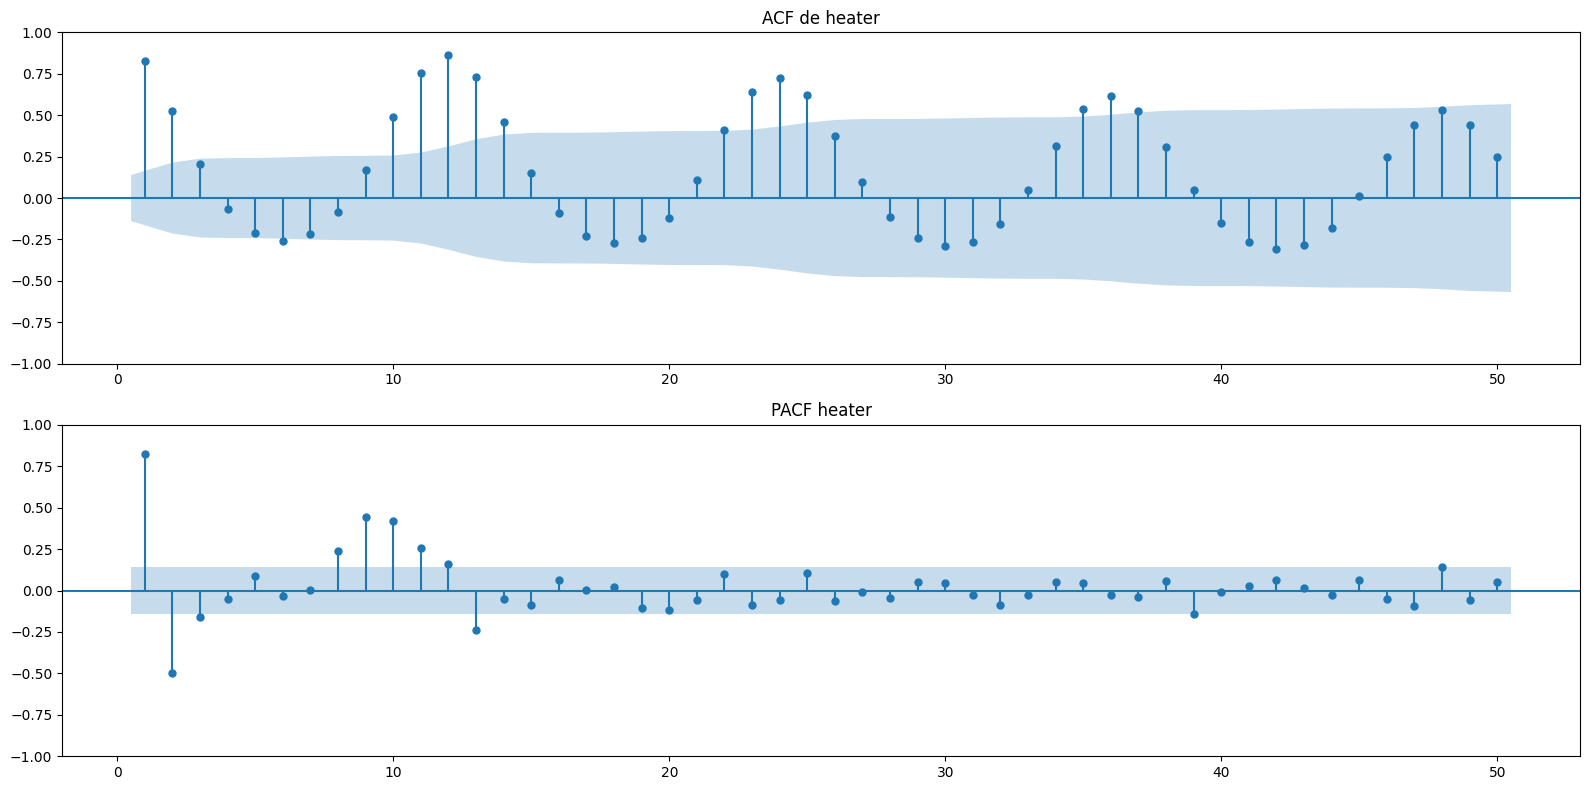

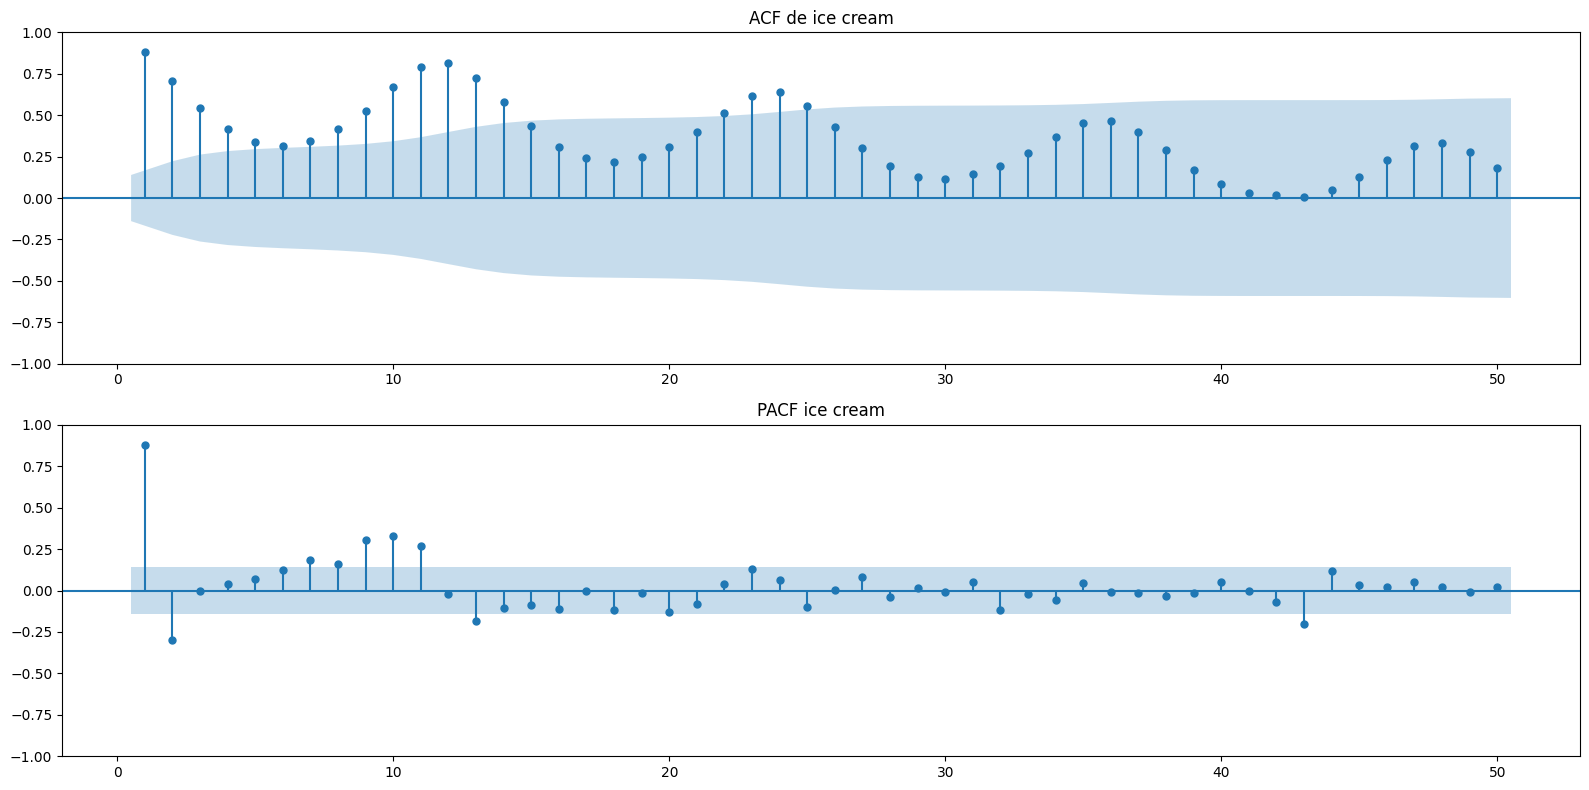

In [8]:
# Faire les tests de Dickey-Fuller augmenté
for column in df.columns:
    result = adfuller(df[column])
    print(f"\nResults for column {column}:")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Faire les graphiques ACF et PACF pour chaque colonne
for column in df.columns:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
    plot_acf(df[column], lags=50, zero=False, ax=ax1)
    ax1.set_title(f"ACF de {column}")
    plot_pacf(df[column], lags=50, zero=False, ax=ax2)
    ax2.set_title(f"PACF {column}")
    plt.tight_layout()
    plt.show()

# Transformation pour rendre la série stationnaire

In [9]:
# Différencier les séries de données et les ajouter au DataFrame
df_diff = df.diff().dropna()
df_diff.columns = [f"{col}_diff" for col in df.columns]
df = pd.concat([df, df_diff], axis=1)
df

,heater,ice cream,heater_diff,ice cream_diff
Month,,,,
2004-01-01,27,13,NaN,NaN
2004-02-01,18,15,-9.0,2.0
2004-03-01,14,16,-4.0,1.0
2004-04-01,13,19,-1.0,3.0
2004-05-01,13,21,0.0,2.0
...,...,...,...,...
2020-02-01,34,45,-7.0,2.0
2020-03-01,25,44,-9.0,-1.0
2020-04-01,25,53,0.0,9.0


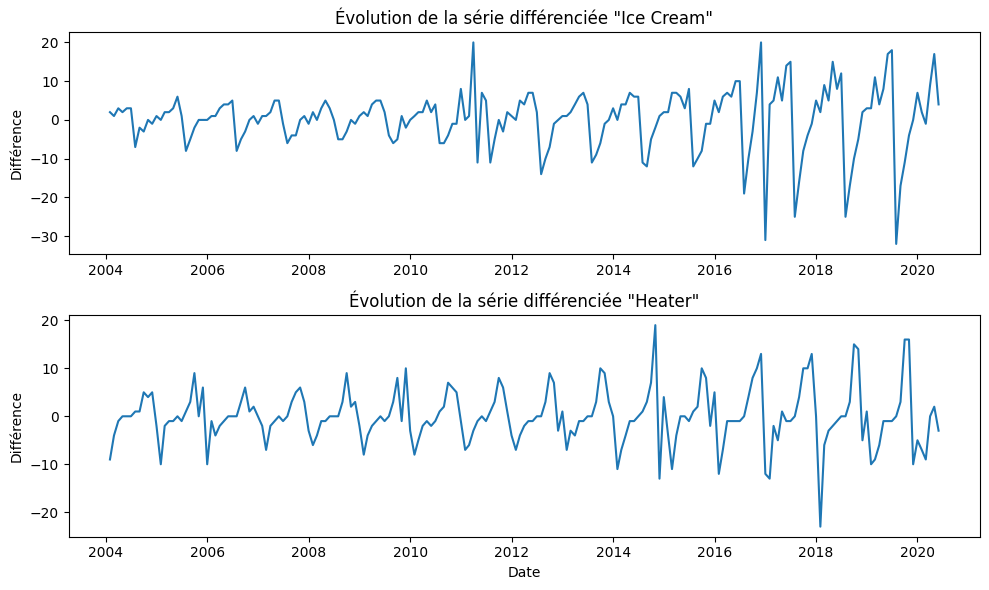

In [10]:
# Tracer les graphiques
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df_diff.index, df_diff['ice cream_diff'])
plt.title('Évolution de la série différenciée "Ice Cream"')
plt.ylabel('Différence')

plt.subplot(2, 1, 2)
plt.plot(df_diff.index, df_diff['heater_diff'])
plt.title('Évolution de la série différenciée "Heater"')
plt.xlabel('Date')
plt.ylabel('Différence')

plt.tight_layout()
plt.show()


Results for column heater_diff:
ADF Statistic: -16.967314
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575

Results for column ice cream_diff:
ADF Statistic: -4.781718
p-value: 0.000059
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


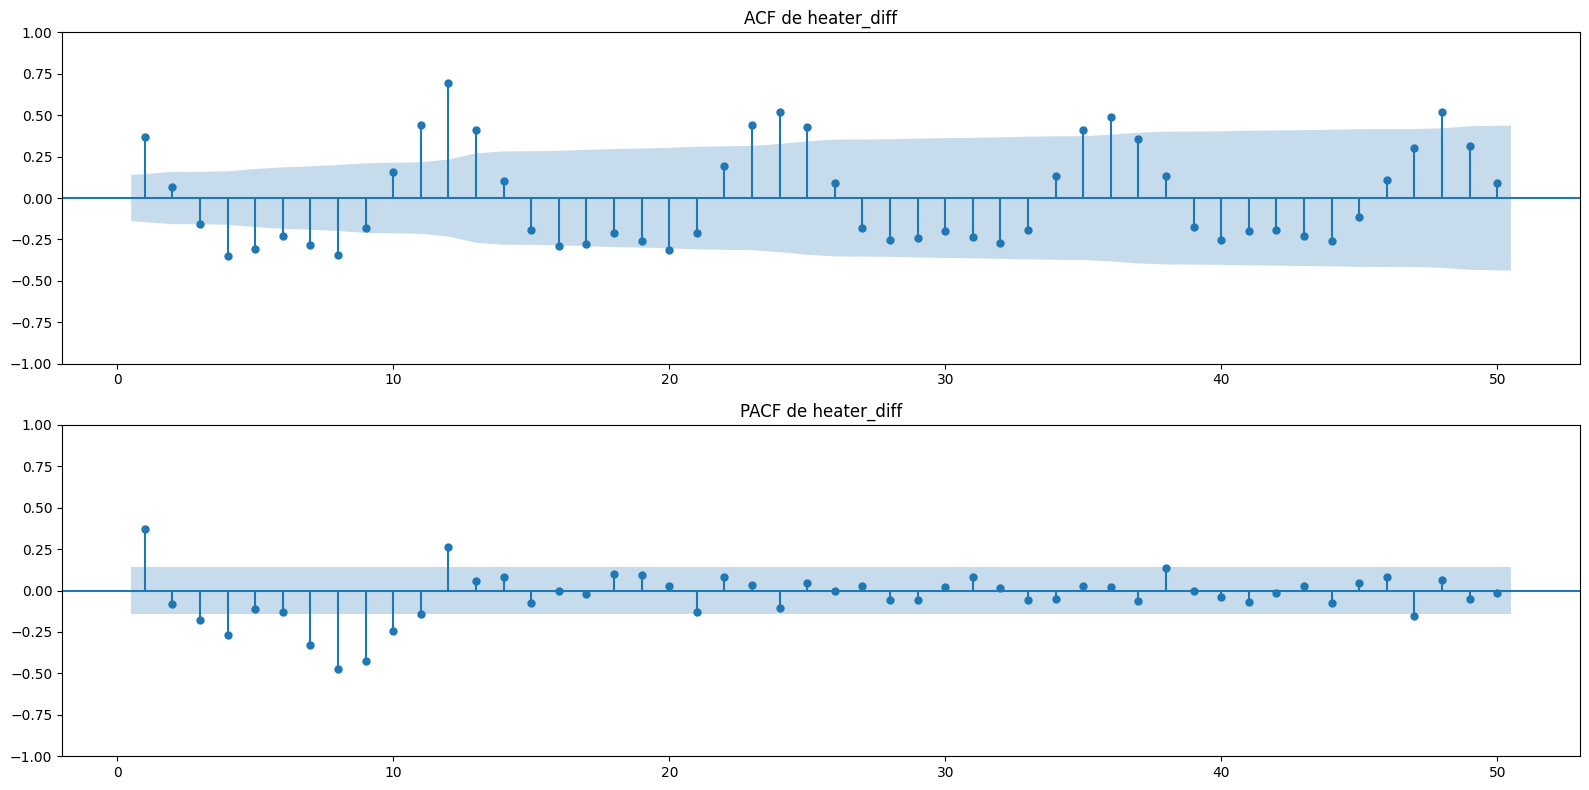

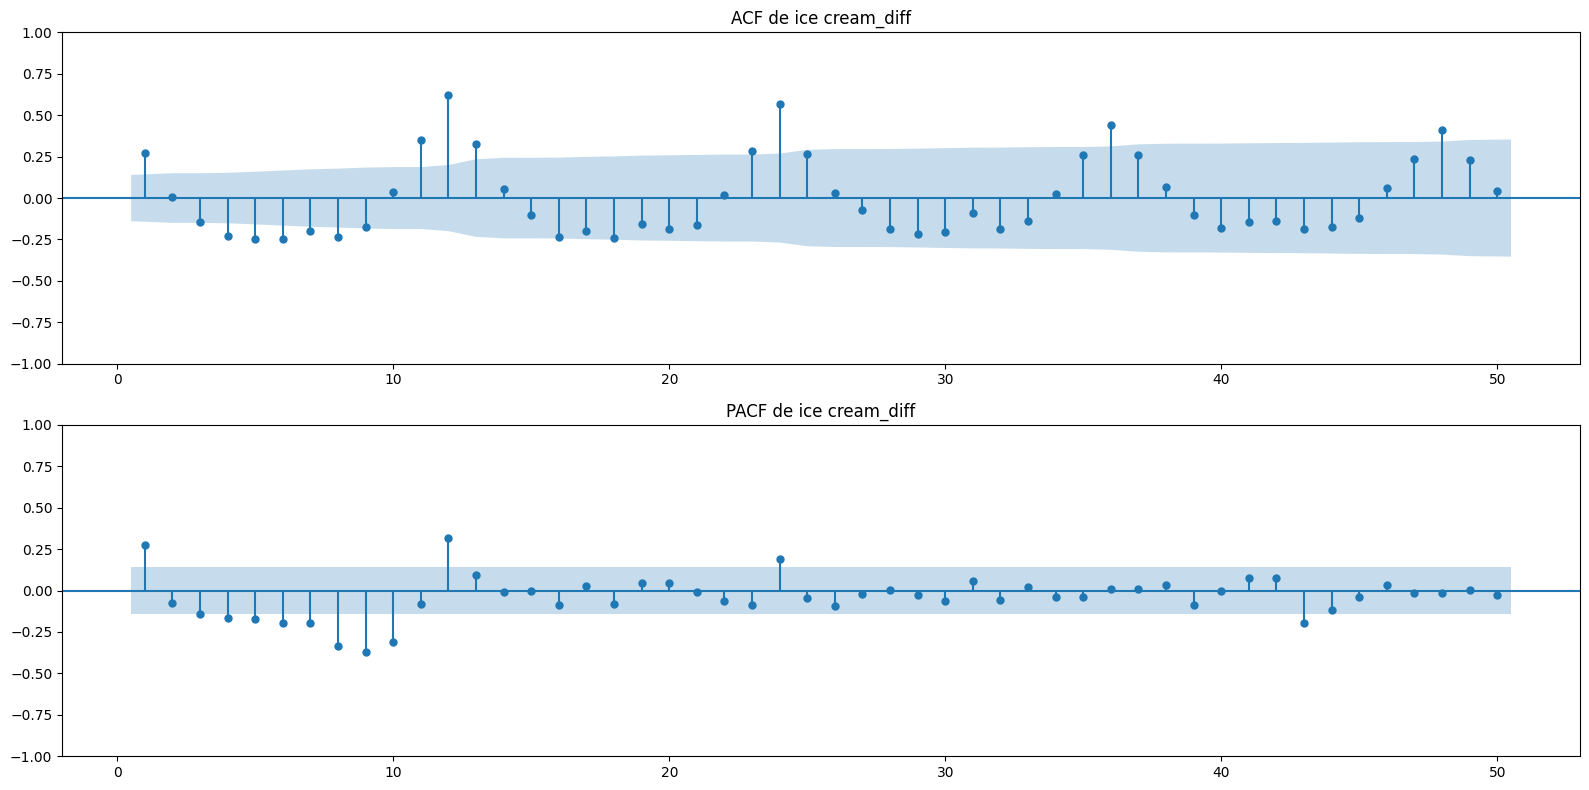

In [11]:
# Faire les tests de Dickey-Fuller augmenté pour les séries différenciées
for column in df_diff.columns:
    result = adfuller(df_diff[column])
    print(f"\nResults for column {column}:")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Faire les graphiques ACF et PACF pour chaque colonne différenciée
for column in df_diff.columns:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
    plot_acf(df_diff[column], lags=50, zero=False, ax=ax1)
    ax1.set_title(f"ACF de {column}")
    plot_pacf(df_diff[column], lags=50, zero=False, ax=ax2)
    ax2.set_title(f"PACF de {column}")
    plt.tight_layout()
    plt.show()

# Division de la base en train et en base test

In [12]:
# Définir le point de division
split_point = int(len(df_diff) * 0.9)  # 90% des données pour l'entraînement

# Diviser les données
df_train = df_diff.iloc[:split_point]
df_test = df_diff.iloc[split_point:]

# Vérifier les tailles des ensembles d'entraînement et de test
print('Training set:', len(df_train))
print('Test set:', len(df_test))

Training set: 177
Test set: 20


# Choix du p optimal

In [13]:
# Choisir l'ordre optimal du modèle VAR
model = VAR(df_train)

# Choisir l'ordre optimal p pour le modèle VAR
order_selection = model.select_order(maxlags=12)
order_selection.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,7.410,7.447,1652.,7.425
1,7.135,7.248,1255.,7.181
2,7.032,7.221,1133.,7.109
3,6.811,7.074,907.8,6.918
4,6.392,6.731,597.4,6.530
5,6.006,6.421,406.2,6.175
6,5.572,6.062,263.2,5.771
7,5.477,6.042,239.4,5.707
8,5.332,5.972,207.1,5.591
9,5.243,5.959*,189.7,5.534


In [14]:
# L'ordre optimal est donné par le critère d'information d'Akaike (AIC) ou le critère d'information bayésien (BIC)
optimal_order_aic = order_selection.aic
optimal_order_bic = order_selection.bic
optimal_order_fpe = order_selection.fpe
optimal_order_hqic = order_selection.hqic

print(f"P optimal avec AIC: {optimal_order_aic}")
print(f"P optimal avec BIC: {optimal_order_bic}")
print(f"P optimal avec FPE: {optimal_order_fpe}")
print(f"P optimal avec HQIC: {optimal_order_hqic}")

P optimal avec AIC: 12
P optimal avec BIC: 9
P optimal avec FPE: 12
P optimal avec HQIC: 12


# Estimation du modèle

In [27]:
# Créer le modèle VAR
model = VAR(df_train)

# Choisir un ordre 4
results = model.fit(9)

# Voir un sommaire des résultats
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Nov, 2025
Time:                     10:55:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.93032
Nobs:                     168.000    HQIC:                   5.51048
Log likelihood:          -877.555    FPE:                    185.982
AIC:                      5.22371    Det(Omega_mle):         150.109
--------------------------------------------------------------------
Results for equation heater_diff
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.443788         0.242540            1.830           0.067
L1.heater_diff           -0.532514         0.078948           -6.745           0.000
L1.ice cream_diff        -0.044287    

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Le modèle VAR ajusté sur les variables différenciées heater_diff et ice cream_diff présente une bonne qualité d'ajustement globale. Les critères AIC (5.22), HQIC (5.51) et BIC (5.93) indiquent une spécification raisonnable.
Les équations montrent que :

heater_diff dépend fortement de ses propres retards, avec des coefficients négatifs significatifs (p < 0.01) jusqu'à 9 périodes. Certains retards de ice cream_diff ont aussi un effet significatif, révélant une influence croisée modérée.

ice cream_diff est aussi dominée par ses propres retards, notamment L1, L2, L3, L4 et L5, dont les coefficients sont significatifs et négatifs. Quelques retards de heater_diff (L6, L7, L8) ont un impact positif significatif, indiquant une interaction asymétrique entre les deux séries.

La matrice de corrélation des résidus montre une corrélation modérée (≈ 0.19), ce qui implique que le modèle capture correctement les interdépendances dynamiques sans laisser de corrélation résiduelle excessive.
Globalement, le modèle identifie des relations temporelles solides, avec des effets autorégressifs prédominants et des interactions croisées pertinentes mais plus faibles.

# Validation du modèle

In [28]:
# Obtenir les résidus
residuals = results.resid
residuals

,heater_diff,ice cream_diff
Month,,
2004-11-01,-0.128577,1.919488
2004-12-01,4.249678,-1.653019
2005-01-01,2.109097,0.256936
2005-02-01,-4.762739,-1.732876
2005-03-01,-1.640767,0.270392
...,...,...
2018-06-01,1.236395,-2.640600
2018-07-01,0.532499,6.718003
2018-08-01,0.582671,-7.549477


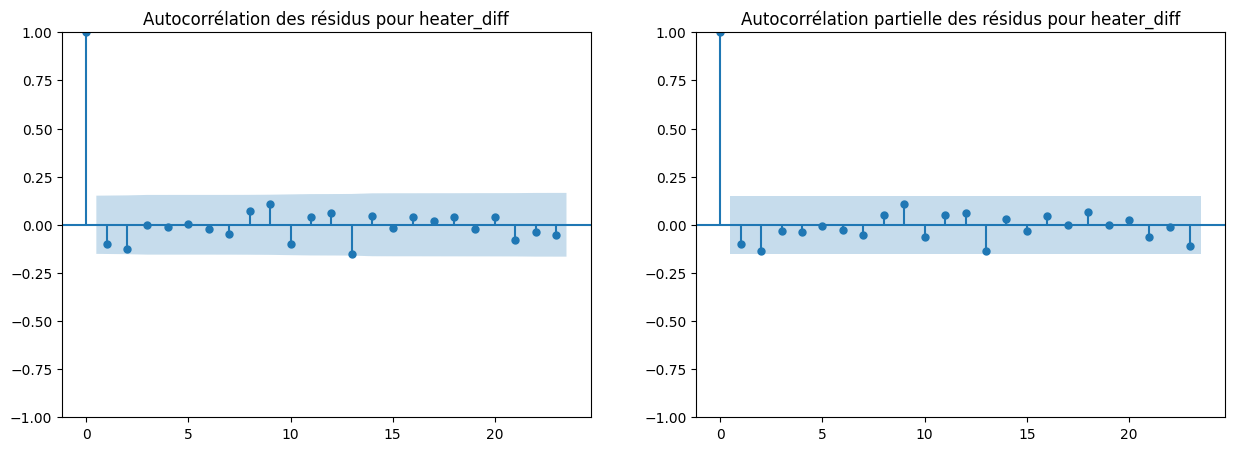

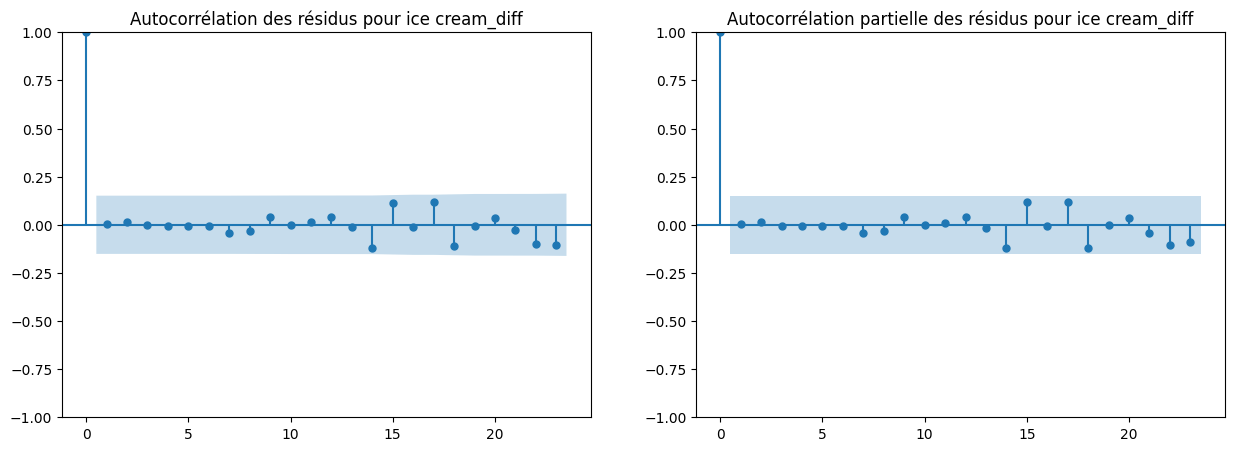

In [29]:
# Tracer l'ACF et le PACF pour chaque série de résidus
for col in residuals.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_acf(residuals[col], ax=axes[0])
    axes[0].set_title(f'Autocorrélation des résidus pour {col}')

    plot_pacf(residuals[col], ax=axes[1])
    axes[1].set_title(f'Autocorrélation partielle des résidus pour {col}')

plt.show()

Les graphiques d’autocorrélation (ACF) et d’autocorrélation partielle (PACF) des résidus pour les deux variables (heater_diff et ice cream_diff) montrent que :

Toutes les autocorrélations aux lags > 0 sont non significatives — elles restent bien à l’intérieur des bandes de confiance (zone bleu clair).

Cela signifie que les résidus ne présentent aucune structure temporelle résiduelle, ce qui est le critère essentiel pour valider un modèle VAR.

En brief:
Le modèle a correctement capturé la dynamique linéaire des séries. Les résidus se comportent comme du bruit blanc, ce qui valide la qualité de l’ajustement et permet d’utiliser le modèle pour des prévisions fiables.

In [30]:
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
# Effectuer des tests sur les résidus
for col in residuals.columns:
    print(f"Résidus pour {col}:")
    jb_test = jarque_bera(residuals[col])
    print(f"Test de Jarque-Bera: statistic={jb_test[0]}, p-value={jb_test[1]}")

Résidus pour heater_diff:
Test de Jarque-Bera: statistic=71.31313508188764, p-value=3.27001295593489e-16
Résidus pour ice cream_diff:
Test de Jarque-Bera: statistic=379.9000763932217, p-value=3.2043988994044887e-83


Dans les deux cas, la p-value est extrêmement faible (≪ 0.001), ce qui conduit à rejeter fortement l’hypothèse de normalité.

Cela indique que les résidus présentent probablement une asymétrie et/ou des queues plus lourdes que la loi normale.

In [31]:
# Préparer une liste pour stocker les dictionnaires de résultats
results_list = []

# Effectuer le test de Ljung-Box pour des décalages de 1 à 12
for col in residuals.columns:
    for lag in range(1, 13):
        lb_test = acorr_ljungbox(residuals[col], lags=[lag], return_df=True)
        results_list.append({
            'Variable': col,
            'Lag': lag,
            'LB Statistic': lb_test['lb_stat'].values[0],
            'LB P-value': lb_test['lb_pvalue'].values[0]
        })

# Créer le DataFrame à partir de la liste de dictionnaires
results_df = pd.DataFrame(results_list)

# Afficher les résultats
print(results_df)

          Variable  Lag  LB Statistic  LB P-value
0      heater_diff    1      1.721963    0.189441
1      heater_diff    2      4.489568    0.105950
2      heater_diff    3      4.490690    0.213122
3      heater_diff    4      4.523101    0.339817
4      heater_diff    5      4.523923    0.476689
5      heater_diff    6      4.601538    0.595835
6      heater_diff    7      4.986320    0.661633
7      heater_diff    8      5.875521    0.661173
8      heater_diff    9      7.881764    0.546104
9      heater_diff   10      9.750827    0.462619
10     heater_diff   11     10.060009    0.524998
11     heater_diff   12     10.721531    0.552922
12  ice cream_diff    1      0.005986    0.938328
13  ice cream_diff    2      0.055679    0.972545
14  ice cream_diff    3      0.057998    0.996349
15  ice cream_diff    4      0.061965    0.999530
16  ice cream_diff    5      0.066415    0.999941
17  ice cream_diff    6      0.077808    0.999990
18  ice cream_diff    7      0.415322    0.999701


Le test de Ljung-Box a été appliqué aux résidus de chaque équation du modèle VAR jusqu’au lag 12 :

Pour heater_diff, toutes les p-values sont supérieures à 0.05 (minimum ≈ 0.106 au lag 2).
Pour ice cream_diff, les p-values sont toutes très élevées (≥ 0.93), indiquant une absence quasi parfaite d’autocorrélation.

On ne rejette pas l’hypothèse nulle d’absence d’autocorrélation des résidus à aucun des lags testés.
Cela confirme que les résidus se comportent comme un bruit blanc, et que le modèle VAR a correctement capturé la structure dynamique des séries.

# Prédiction des series

In [32]:
# Prévoir les valeurs sur l'ensemble d'entraînement
# Prédictions sur les ensembles d'entraînement et de test
train_pred = results.fittedvalues
test_pred = results.forecast(df_train.values, steps=len(df_test))

In [34]:
# Créer un DataFrame avec les prédictions
train_pred_df = pd.DataFrame(train_pred, columns=df_train.columns)
train_pred_df['Date'] = df_train.index[9:]  # Ajouter les dates correspondant à l'ensemble d'entraînement
train_pred_df.set_index('Date', inplace=True)  # Utiliser les dates comme indices

test_pred_df = pd.DataFrame(test_pred, columns=df_train.columns)
test_pred_df['Date'] = df_diff.index[len(df_train):]  # Ajouter les dates correspondant à l'ensemble d'entraînement
test_pred_df.set_index('Date', inplace=True)  # Utiliser les dates comme indices

# Représentation graphique

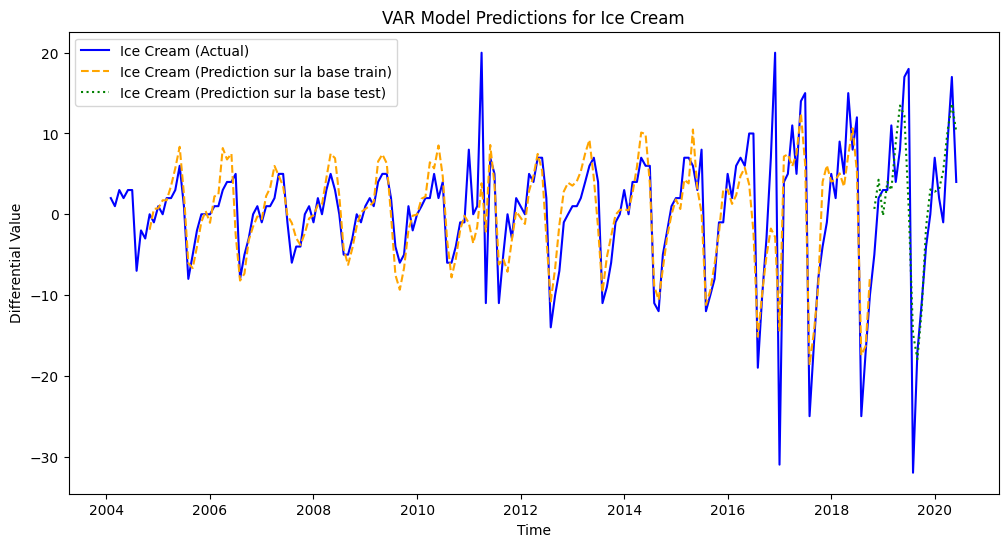

In [35]:
# Graphique pour Ice Cream
plt.figure(figsize=(12, 6))
plt.plot(df_diff.index, df_diff['ice cream_diff'], label='Ice Cream (Actual)', color='blue')
plt.plot(train_pred_df.index, train_pred_df['ice cream_diff'], label='Ice Cream (Prediction sur la base train)', linestyle='dashed', color='orange')
plt.plot(test_pred_df.index, test_pred_df['ice cream_diff'], label='Ice Cream (Prediction sur la base test)', linestyle='dotted', color='green')
plt.xlabel('Time')
plt.ylabel('Differential Value')
plt.title('VAR Model Predictions for Ice Cream')
plt.legend()
plt.show()

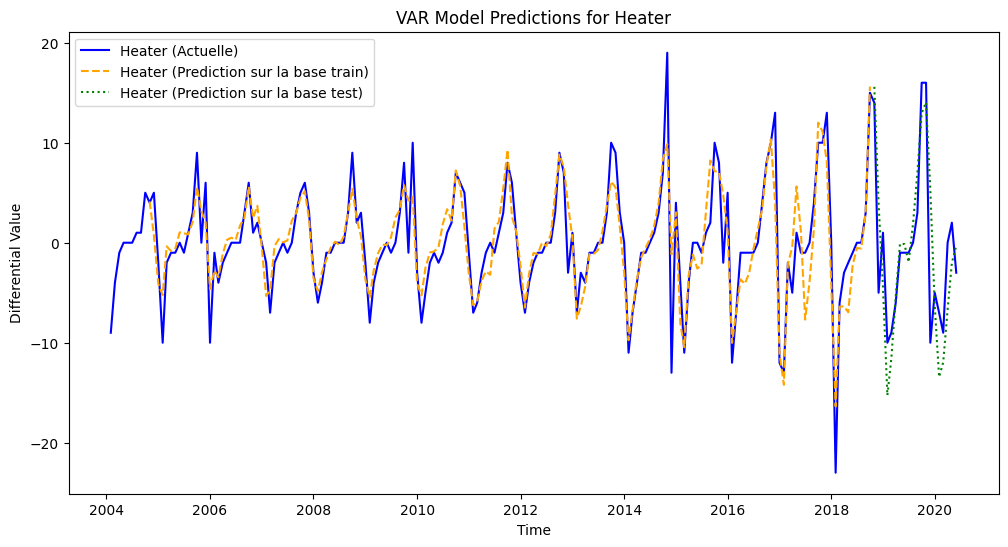

In [36]:
# Graphique pour Heater
plt.figure(figsize=(12, 6))
plt.plot(df_diff.index, df_diff['heater_diff'], label='Heater (Actuelle)', color='blue')
plt.plot(train_pred_df.index, train_pred_df['heater_diff'], label='Heater (Prediction sur la base train)', linestyle='dashed', color='orange')
plt.plot(test_pred_df.index, test_pred_df['heater_diff'], label='Heater (Prediction sur la base test)', linestyle='dotted', color='green')
plt.xlabel('Time')
plt.ylabel('Differential Value')
plt.title('VAR Model Predictions for Heater')
plt.legend()
plt.show()

# Calcul des métrics

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred, model_name="VAR"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))


    return pd.DataFrame({
        'MAE': [mae],
        'RMSE': [rmse]
    }, index=[model_name])

# Évaluer pour chaque variable
metrics_heater = calculate_metrics(df_test['heater_diff'], test_pred_df['heater_diff'], 'heater_diff')
metrics_ice = calculate_metrics(df_test['ice cream_diff'], test_pred_df['ice cream_diff'], 'ice cream_diff')

print("Performance sur l'ensemble de test :")
print(pd.concat([metrics_heater, metrics_ice]))

Performance sur l'ensemble de test :
                     MAE      RMSE
heater_diff     3.865391  5.167304
ice cream_diff  4.963569  6.715652


Les erreurs de prédiction sur l’ensemble de test sont évaluées à l’aide de deux indicateurs classiques :

MAE (Mean Absolute Error) : représente l’erreur moyenne absolue, en unités de la série différenciée.
→ Pour heater_diff, l’erreur moyenne est de ≈ 3.87 unités ; pour ice cream_diff, ≈ 4.96 unités.
RMSE (Root Mean Squared Error) : pénalise davantage les erreurs importantes grâce à la mise au carré.
→ Valeurs de ≈ 5.17 et ≈ 6.72, respectivement, ce qui reste cohérent avec les MAE et indique l’absence d’erreurs extrêmes très marquées.